In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils import parameters_to_vector
from torchinfo import summary
from brevitas.nn import QuantConv2d

import matplotlib.pyplot as plt

import modules.models_bed_evolution.bed_05_brevitas_fpga_old_small_big as cnv_model

# Load Model

In [2]:
device = 'cpu'

In [3]:
model = cnv_model.BED_AIMET_FPGA_MANUAL_OLD_SMALL_BIG().to(device)

### Parameters

In [4]:
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(model.parameters()).numel()
print(f'Total parameters = {n_params}\n')


Trainable parameters = 64353
Total parameters = 64353



### Check Model Shape: Random Input

In [5]:
dummy_input = np.random.rand(4, 3, 230, 230)
dummy_input = torch.tensor(dummy_input, dtype=torch.float32, device=device)
out_test = model(dummy_input)
print(f'Model shape is {out_test}')

/opt/conda/envs/pytorch_brevitas/lib/python3.10/site-packages/torch/_tensor.py:1362: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400410390/work/c10/core/TensorImpl.h:1900.)
  return super().rename(names)


Model shape is tensor([[-1.3145, -1.5105],
        [-0.1888,  0.6476],
        [ 1.8313, -0.0123],
        [ 0.3623,  0.1848]], grad_fn=<AddBackward0>)


### Torchinfo

In [7]:
print(summary(model, input_size=(1, 3, 230, 230)))

Layer (type:depth-idx)                                                      Output Shape              Param #
BED_AIMET_FPGA_MANUAL_OLD_SMALL_BIG                                         [1, 2]                    --
├─Sequential: 1-1                                                           [1, 64, 20, 20]           62,173
│    └─QuantIdentity: 2-1                                                   [1, 3, 230, 230]          --
│    │    └─ActQuantProxyFromInjector: 3-1                                  [1, 3, 230, 230]          --
│    │    └─ActQuantProxyFromInjector: 3-2                                  [1, 3, 230, 230]          1
├─Sequential: 1-36                                                          --                        (recursive)
│    └─QuantReLU: 2-51                                                      --                        (recursive)
│    │    └─ActQuantProxyFromInjector: 3-88                                 --                        (recursive)
├─Sequential: 1-37  

## Model Paths

In [8]:
folder_path = './experiments_bed_evolution/71_brevitas__230_manual_old_SmallBig__full_ds/weights'
model_path = folder_path + '/BED_FPGA_230_classifier__best_mean_F1.pt'

## Load Checkpoint

In [9]:
def load_checkpoint(model_path, model, optimizer=None, scheduler=None, device='cpu'):
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"Loading Model. Trained during {start_epoch} epochs")
    return start_epoch

In [10]:
load_checkpoint(model_path, model)

Loading Model. Trained during 131 epochs


131

In [11]:
model.cpu();
model.eval();

# Check Sparsity

In [12]:
a = torch.tensor(np.array([[[0,1,2],[3,4,5]]]))
print(a.shape)
zzz = a == 0
print(torch.sum(zzz))

torch.Size([1, 2, 3])
tensor(1)


In [13]:
zero_channels = {}
sparsity = {}

for name, mod in model.named_modules():
    if isinstance(mod, QuantConv2d):
        print("QuantConv2d", name)
    if isinstance(mod, nn.Conv2d) or isinstance(mod, nn.BatchNorm2d):
        w_layer = mod.weight.detach().clone()
        w_layer[w_layer < 1e-20] = 0
        oup_channels = mod.weight.shape[0]
        
        if isinstance(mod, nn.Conv2d):
            layer_type = "conv"
        elif isinstance(mod, nn.BatchNorm2d):
            layer_type = "batchnorm"
        # Number of zeros to calculate sparsity
        zero_idx = w_layer < 1e-20
        zero_weights_other = torch.sum(zero_idx)
        total_weights = torch.numel(mod.weight)
        zero_weights = total_weights - torch.count_nonzero(w_layer)
        assert zero_weights == zero_weights_other, "Zeros are different"
        layer_sparsity = zero_weights / total_weights
        sparsity[name] = {"layer type": layer_type, "sparsity": layer_sparsity}
        zero_channel_list = []
        print(f'Layer name: {name} - Layer type: {layer_type} - Number of weights: {torch.numel(mod.weight)} - Sparsity: {layer_sparsity:.2f}')
        #print(f'\tWeights shape: {w_layer.shape}')
        
        for i in range(oup_channels):
            w = mod.weight[i].detach().clone()
            w[w < 1e-10] = 0
            if len(w.nonzero()) == 0:
                zero_channel_list.append(i)
        zero_channels[name] = {"layer type": layer_type, "output channels": oup_channels, "zero channels": zero_channel_list}

QuantConv2d features.1.0
Layer name: features.1.0 - Layer type: conv - Number of weights: 324 - Sparsity: 0.49
Layer name: features.1.1 - Layer type: batchnorm - Number of weights: 12 - Sparsity: 0.00
QuantConv2d features.3.0
Layer name: features.3.0 - Layer type: conv - Number of weights: 864 - Sparsity: 0.50
Layer name: features.3.1 - Layer type: batchnorm - Number of weights: 24 - Sparsity: 0.00
QuantConv2d features.3.3
Layer name: features.3.3 - Layer type: conv - Number of weights: 1152 - Sparsity: 0.51
Layer name: features.3.4 - Layer type: batchnorm - Number of weights: 16 - Sparsity: 0.00
QuantConv2d features.5.0
Layer name: features.5.0 - Layer type: conv - Number of weights: 256 - Sparsity: 0.55
Layer name: features.5.1 - Layer type: batchnorm - Number of weights: 16 - Sparsity: 0.00
QuantConv2d features.6.0
Layer name: features.6.0 - Layer type: conv - Number of weights: 768 - Sparsity: 0.47
Layer name: features.6.1 - Layer type: batchnorm - Number of weights: 16 - Sparsity:

## Sparse Zero Channels

In [14]:
for k, v in zero_channels.items():
    #print(k, v, len(v))
    print(f'Layer name: {k:<20} Layer type: {v["layer type"]:<10} - Output channels: {v["output channels"]:<4} - Zero channels: {len(v["zero channels"])}')

Layer name: features.1.0         Layer type: conv       - Output channels: 12   - Zero channels: 0
Layer name: features.1.1         Layer type: batchnorm  - Output channels: 12   - Zero channels: 0
Layer name: features.3.0         Layer type: conv       - Output channels: 24   - Zero channels: 0
Layer name: features.3.1         Layer type: batchnorm  - Output channels: 24   - Zero channels: 0
Layer name: features.3.3         Layer type: conv       - Output channels: 16   - Zero channels: 0
Layer name: features.3.4         Layer type: batchnorm  - Output channels: 16   - Zero channels: 0
Layer name: features.5.0         Layer type: conv       - Output channels: 16   - Zero channels: 0
Layer name: features.5.1         Layer type: batchnorm  - Output channels: 16   - Zero channels: 0
Layer name: features.6.0         Layer type: conv       - Output channels: 16   - Zero channels: 0
Layer name: features.6.1         Layer type: batchnorm  - Output channels: 16   - Zero channels: 0
Layer name

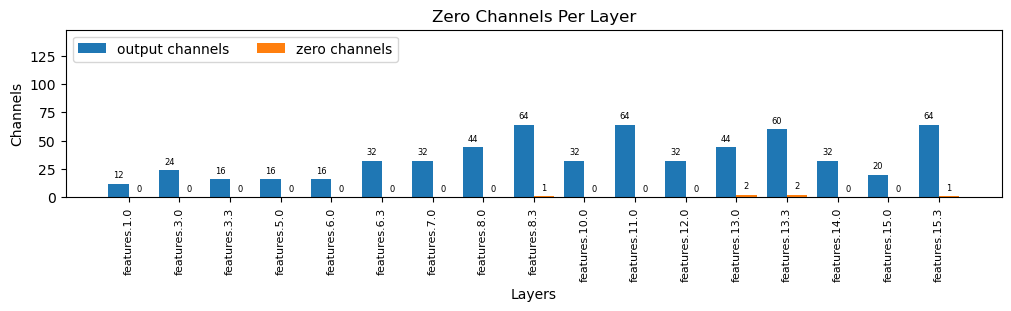

In [15]:
zero_channel_layer = {
    "output channels": list(v["output channels"] for v in zero_channels.values() if v["layer type"] == "conv"),
    "zero channels": list(len(v["zero channels"]) for v in zero_channels.values() if v["layer type"] == "conv"),
}

zero_channels_layer_names = [k for k in zero_channels.keys() if zero_channels[k]["layer type"] == "conv"] 

x = np.arange(len(zero_channels_layer_names))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(10, 3))

for attribute, measurement in zero_channel_layer.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, fontsize = 6)
    multiplier += 1


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Layers')
ax.set_ylabel('Channels')
ax.set_title('Zero Channels Per Layer')
ax.set_xticks(x + width/2, zero_channels_layer_names, rotation=90, fontsize = 8)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 148)

plt.show()

## Sparsity per layer

### All Layers

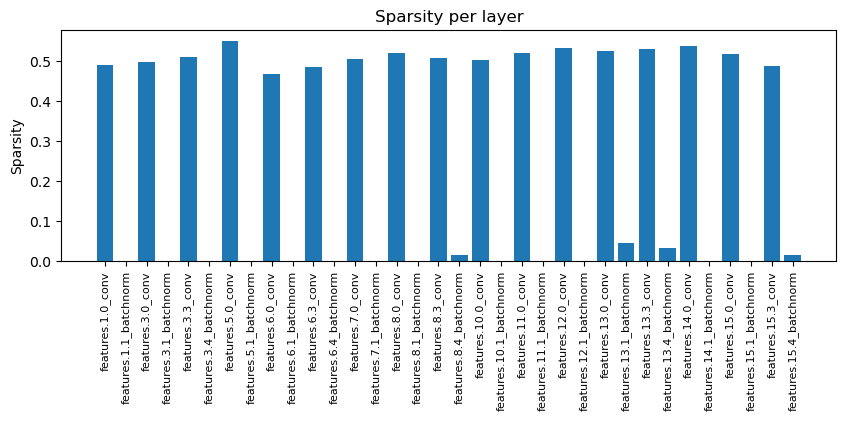

In [16]:
fig, ax = plt.subplots(figsize=(10,3))

layers_name = [k + "_" + sparsity[k]["layer type"] for k in sparsity.keys()]
counts = [v["sparsity"] for v in sparsity.values()]

ax.bar(layers_name, counts)

ax.set_ylabel('Sparsity')
ax.set_title('Sparsity per layer')
ax.set_xticks(np.arange(len(layers_name)), layers_name, rotation=90, fontsize=8)

plt.show()

### Only Batch Norm

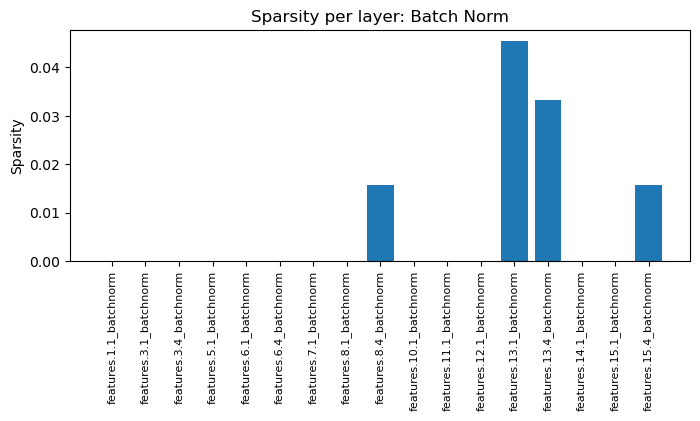

In [17]:
fig, ax = plt.subplots(figsize=(8,3))

layers_name = [k + "_" + sparsity[k]["layer type"] for k in sparsity.keys() if sparsity[k]["layer type"] == "batchnorm"]
counts = [v["sparsity"] for v in sparsity.values() if v["layer type"] == "batchnorm"]

ax.bar(layers_name, counts)

ax.set_ylabel('Sparsity')
ax.set_title('Sparsity per layer: Batch Norm')
ax.set_xticks(np.arange(len(layers_name)), layers_name, rotation=90, fontsize=8)

plt.show()

### Only Convs

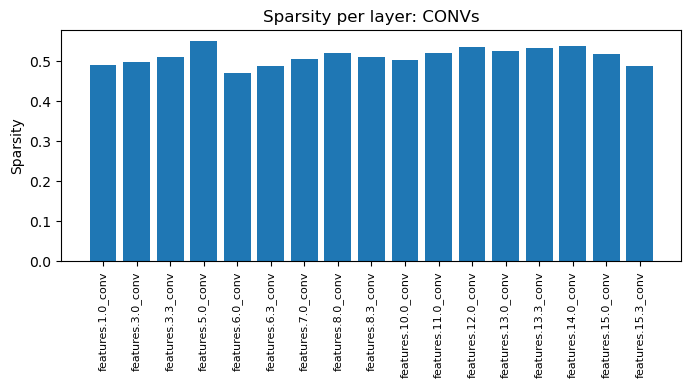

In [18]:
fig, ax = plt.subplots(figsize=(8,3))

layers_name = [k + "_" + sparsity[k]["layer type"] for k in sparsity.keys() if sparsity[k]["layer type"] == "conv"]
counts = [v["sparsity"] for v in sparsity.values() if v["layer type"] == "conv"]

ax.bar(layers_name, counts)

ax.set_ylabel('Sparsity')
ax.set_title('Sparsity per layer: CONVs')
ax.set_xticks(np.arange(len(layers_name)), layers_name, rotation=90, fontsize=8)

plt.show()